# Plan




1. Get gradients on transition matrix for n-steps [X]
2. Figure out what to multiply a vector by to obtain skew-symmetric matrix - [x] 
    -1. A~
3. Use caley transform to generate a unitary matrix - [x] 
4. Run whole thing through jax to get PI representation [X]

In [1]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
import seaborn
import scipy.optimize as op
from functools import partial
seaborn.set(font_scale=1.5,style='ticks')

/Users/yves/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


# Run with jax

In [83]:
dim = 4
nT = 9
x0 = np.random.normal(size=(dim,1))
A_ = np.random.normal(size=(dim,dim))

A = np.zeros([dim,dim])

for i in range(dim):
    A[i,i:] = A_[i:,i]
    A[i:,i] = -A_[i:,i]
    
A[np.diag_indices_from(A)] = 0
A = (np.eye(dim)-A)@np.linalg.inv(np.eye(dim)+A)

x = np.array([np.linalg.matrix_power(A,i)@x0 for i in range(9)])

In [84]:
#plt.plot(x[:,1])
#plt.yscale('symlog')

In [85]:
Ahat = np.random.normal(size=(dim,dim))


In [86]:
import jax.numpy as jnp
from jax import grad, jit, vmap
from jax import random


In [87]:
def predict(Ahat,x,y,n,dim):
    Ahat = jnp.reshape(Ahat,(dim,dim))
    return jnp.sum((jnp.dot(jnp.linalg.matrix_power(Ahat,n),x)-y)**2)


predict_funs = [partial(predict,n=i,dim=dim) for i in range(9)]
grad_predict_funs = [grad(i) for i in predict_funs]

In [88]:
def get_basis_tensor(dim):
    """ Returns a tensor that forms a basis for skew symmetric matrices.
        Use np.einsum('i...,i...',params,basis_tensor) to construct this
        matrix
    """
    basis_tensor = []
    for i in range(dim):
        for j in range(i+1,dim):
            bi =  np.zeros([dim,dim])
            bi[i,j] = -1
            bi = bi -bi.T
            basis_tensor.append(bi.T)
    basis_tensor = np.array(basis_tensor)
    return np.asarray(basis_tensor)


In [89]:
basis_tensor = get_basis_tensor(dim)
n_bases = basis_tensor.shape[0]

In [90]:
def caley_transform(skewM,dim):
    """ Perform Caley transform"""
    return (np.eye(dim) - skewM)@np.linalg.inv(np.eye(dim)+skewM)

In [91]:
def predict_all(Ahat,x,predict_funs,grad_predict_funs,dim):
    Ahat = Ahat.reshape(dim,dim)
    #print(Ahat.shape)
    err = 0
    nT = len(x)
    k = 0
    for start_state in range(nT):
        for pred_state in range(start_state+1,nT-start_state):
            n_fwd = pred_state-start_state 
            err += predict_funs[n_fwd](Ahat,x[start_state],x[pred_state])
            k += 1
    return err/k


def predict_all_grad(Ahat,x,predict_funs,grad_predict_funs,dim):
    
    #n_ = len(Ahat.flatten())
    Ahat = Ahat.reshape(dim,dim)
    J = np.zeros(Ahat.shape)
    #print(J.shape)
    nT = len(x)
    k = 0
    for start_state in range(nT):
        for pred_state in range(start_state+1,nT):
            n_fwd =  pred_state-start_state 
            #print(n_fwd,J.shape,)
            #print(start_state,pred_state,n_fwd)
            J = J + grad_predict_funs[n_fwd](Ahat,x[start_state],x[pred_state])
            k+= 1
    #J = J/k
    return J.flatten()
    

In [92]:
predict_funs[1](A,x[0],x[1])

DeviceArray(1.7763568e-14, dtype=float32)

In [93]:
dim*(dim-1)/2

6.0

In [94]:
#%%timeit
op.approx_fprime(Ahat.flatten(),
                 predict_all,
                 1e-4,
                 *(x,predict_funs,grad_predict_funs,dim)
            )

array([  70390.625 ,  103007.8125,  191093.75  ,   47382.8125,
       -129843.75  ,  -69843.75  , -152187.5   , -165781.25  ,
        -80937.5   ,  -20429.6875,  -66406.25  , -131289.0625,
        -57734.375 ,   65781.25  ,   93203.125 , -151406.25  ])

In [95]:
grad_predict_all = grad(predict_all)

In [96]:
#%%timeit
grad_predict_all(Ahat,x,predict_funs,grad_predict_funs,dim)

DeviceArray([[  70223.76 ,  102901.92 ,  190926.28 ,   47208.484],
             [-129855.81 ,  -70100.4  , -152130.9  , -165836.36 ],
             [ -80860.266,  -20378.723,  -66509.18 , -131416.02 ],
             [ -57839.285,   65681.766,   92969.32 , -151639.16 ]],            dtype=float32)

In [97]:
predict_all_grad(Ahat,x,predict_funs,grad_predict_funs,dim)

DeviceArray([ 1531008.8 ,  2215244.8 ,  4063375.8 ,  1037155.75,
             -2811138.  , -1510624.  , -3261421.2 , -3558559.2 ,
             -1744138.  ,  -453141.84, -1448596.8 , -2793698.8 ,
             -1251204.9 ,  1415294.6 ,  1959539.4 , -3241711.5 ],            dtype=float32)

In [98]:
params = np.random.normal(size=(1,int(dim*(dim-1)/2)))# + np.eye(dim)
res = op.minimize(predict_all,
           params,
           (x,predict_funs,grad_predict_funs,dim),
           jac=grad_predict_all,
           method='Newton-CG'
           )
print(res.message)

ValueError: cannot reshape array of size 6 into shape (4,4)

In [99]:
res.message

'Optimization terminated successfully.'

In [100]:
Ainf = res.x.reshape(dim,dim)

ValueError: cannot reshape array of size 3 into shape (4,4)

ValueError: matmul: Input operand 1 has a mismatch in its core dimension 0, with gufunc signature (n?,k),(k,m?)->(n?,m?) (size 4 is different from 3)

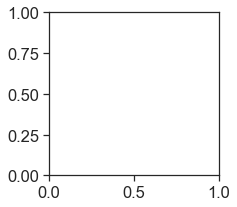

In [101]:
plt.figure(figsize=(14,3))

for i in range(dim):
    
    plt.subplot(1,dim,i+1)
    plt.plot((np.linalg.matrix_power(Ainf,1)@x)[:,i],marker='.')
    plt.plot((np.linalg.matrix_power(A,1)@x)[:,i],marker='.')
    #plt.

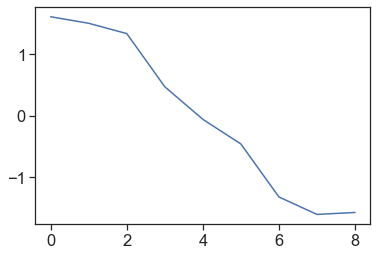

In [102]:
plt.plot((np.linalg.matrix_power(A,5)@x)[:,2])

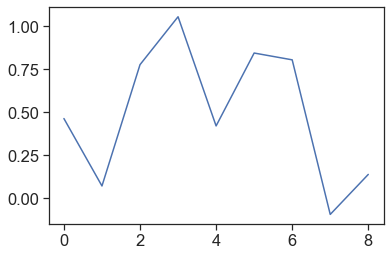

In [103]:
plt.plot(x[:,0])

In [104]:
a = np.random.normal(size=(5,1))
H = np.triu(np.ones([3,3,15]))

# Now do it properly with constraints

In [105]:
def get_basis_tensor(dim):
    """ Returns a tensor that forms a basis for skew symmetric matrices.
        Use np.einsum('i...,i...',params,basis_tensor) to construct this
        matrix
    """
    basis_tensor = []
    for i in range(dim):
        for j in range(i+1,dim):
            bi =  np.zeros([dim,dim])
            bi[i,j] = -1
            bi = bi -bi.T
            basis_tensor.append(bi.T)
    basis_tensor = np.array(basis_tensor)
    return np.asarray(basis_tensor)


In [106]:
def caley_transform(skewM,dim):
    """ Perform Caley transform"""
    return (jnp.eye(dim) - skewM)@jnp.linalg.inv(jnp.eye(dim)+skewM)

In [107]:
params.shape

(1, 6)

In [108]:
def predict(T,x,y,n,dim):
    transition_matrix = jnp.reshape(T,(dim,dim))
    return jnp.sum((jnp.dot(jnp.linalg.matrix_power(transition_matrix,n),x)-y)**2)


#predict_funs = [partial(predict,n=i,dim=dim) for i in range(9)]
#grad_predict_funs = [grad(i) for i in predict_funs]

In [109]:
def predict_all(params,x,dim,basis_tensor):

    err = 0
    nT = len(x)
    k = 0
    skewM = jnp.einsum('i...,i...',params,basis_tensor)
    M = caley_transform(skewM,dim)
    #print(M.shape)
    for start_state in range(nT):
        for pred_state in range(start_state+1,nT-start_state):
            n_fwd = pred_state-start_state 
            err += predict(M,x[start_state],x[pred_state],n_fwd,dim)
            k += 1
    mse = err/k
    print(mse)
    return mse


In [110]:
x.shape

(9, 4, 1)

In [111]:
A

array([[-0.25818356, -0.03906336,  0.3074596 ,  0.91503218],
       [-0.22307136,  0.79814255,  0.52115228, -0.20398026],
       [ 0.70860482, -0.24247544,  0.66182291, -0.03279184],
       [-0.61762418, -0.5501347 ,  0.44255998, -0.34645758]])

In [112]:
grad_predict_all = grad(predict_all)

In [113]:
a = grad_predict_all(jnp.array(res.x),x,dim,basis_tensor)

ValueError: Size of label 'i' for operand 1 (3) does not match previous terms (6).

In [114]:
a

array([[ 1.40950832],
       [-2.45655622],
       [-0.97976705],
       [ 2.28109521],
       [-1.57091309]])

In [115]:
def grad_wrapper(params,x,dim,basis_tensor):
    grad = grad_predict_all(jnp.array(params),x,dim,basis_tensor)
    grad = np.array(grad)
    print(grad)
    return grad

## Generate Data

In [116]:
dim = 3
nT = 9

frac = .3

x0 = np.random.normal(size=(dim,1))
A_ = np.random.normal(size=(dim,dim))

A = np.zeros([dim,dim])

for i in range(dim):
    A[i,i:] = A_[i:,i]
    A[i:,i] = -A_[i:,i]
    
A[np.diag_indices_from(A)] = 0
A = (np.eye(dim)-A)@np.linalg.inv(np.eye(dim)+A)

x = np.array([np.linalg.matrix_power(A,i)@x0 for i in range(nT)])

x = frac*x + (1-frac)*np.random.normal(size=x.shape)

basis_tensor = get_basis_tensor(dim)
n_bases = basis_tensor.shape[0]

In [117]:
I = np.eye(dim)
skewORG = (I-A)@np.linalg.inv(I+A)

In [118]:
params = []

n = skewORG.shape[0]
for i in range(n):
    for j in range(i+1,n):
        params.append(skewORG[i,j])
    

In [119]:
params

[-0.9715445987522557, 1.076800995929212, -0.9457779579113131]

In [120]:
predict_all(params,x,dim,basis_tensor)

1.5497468


DeviceArray(1.5497468, dtype=float32)

In [121]:
basis_tensor = get_basis_tensor(dim)
n_bases = basis_tensor.shape[0]

In [122]:
grad_predict_all = grad(predict_all)

In [123]:
#np.einsum('i...,i...',params,basis_tensor)

In [124]:
#out = op.brute(predict_all,
#               [(0,1)]*3,
#               (x,dim,basis_tensor))

In [140]:
n_params = int(dim*(dim-1)/2)
params = np.random.normal(size=(n_params))# + np.eye(dim)
res = op.minimize(predict_all,
           params,
           (x,dim,basis_tensor),
           jac=grad_wrapper,
           method='BFGS'
           )
print(res.message)

1.726786
Traced<ConcreteArray(1.7267860174179077, dtype=float32)>with<JVPTrace(level=2/0)> with
  primal = DeviceArray(1.726786, dtype=float32)
  tangent = Traced<ShapedArray(float32[])>with<JaxprTrace(level=1/0)> with
    pval = (ShapedArray(float32[]), *)
    recipe = JaxprEqnRecipe(eqn_id=<object object at 0x7f87e9e13630>, invars=(Traced<ConcreteArray(20.0, dtype=float32):JaxprTrace(level=1/0)>, Traced<ShapedArray(float32[]):JaxprTrace(level=1/0)>), outvars=[<weakref at 0x7f87a8a49650; to 'JaxprTracer' at 0x7f87a8a49830>], primitive=xla_call, params={'device': None, 'backend': None, 'name': 'jvp(true_divide)', 'donated_invars': (False, False), 'inline': True, 'call_jaxpr': { lambda ; a:f32[] b:f32[]. let c:f32[] = div b a in (c,) }}, source_info=<jaxlib.xla_extension.Traceback object at 0x7f87d85df530>)
[-0.3294391  -0.11157173  0.02657962]
1.672121
Traced<ConcreteArray(1.6721210479736328, dtype=float32)>with<JVPTrace(level=2/0)> with
  primal = DeviceArray(1.672121, dtype=float32)


Traced<ConcreteArray(1.44255793094635, dtype=float32)>with<JVPTrace(level=2/0)> with
  primal = DeviceArray(1.4425579, dtype=float32)
  tangent = Traced<ShapedArray(float32[])>with<JaxprTrace(level=1/0)> with
    pval = (ShapedArray(float32[]), *)
    recipe = JaxprEqnRecipe(eqn_id=<object object at 0x7f87a897a660>, invars=(Traced<ConcreteArray(20.0, dtype=float32):JaxprTrace(level=1/0)>, Traced<ShapedArray(float32[]):JaxprTrace(level=1/0)>), outvars=[<weakref at 0x7f87e9bf9a10; to 'JaxprTracer' at 0x7f87e9bf9050>], primitive=xla_call, params={'device': None, 'backend': None, 'name': 'jvp(true_divide)', 'donated_invars': (False, False), 'inline': True, 'call_jaxpr': { lambda ; a:f32[] b:f32[]. let c:f32[] = div b a in (c,) }}, source_info=<jaxlib.xla_extension.Traceback object at 0x7f87d89017b0>)
[-0.00647272 -0.18139002  0.05704281]
1.3998101
Traced<ConcreteArray(1.3998100757598877, dtype=float32)>with<JVPTrace(level=2/0)> with
  primal = DeviceArray(1.3998101, dtype=float32)
  tangen

Traced<ConcreteArray(1.2958965301513672, dtype=float32)>with<JVPTrace(level=2/0)> with
  primal = DeviceArray(1.2958965, dtype=float32)
  tangent = Traced<ShapedArray(float32[])>with<JaxprTrace(level=1/0)> with
    pval = (ShapedArray(float32[]), *)
    recipe = JaxprEqnRecipe(eqn_id=<object object at 0x7f87e9e0a660>, invars=(Traced<ConcreteArray(20.0, dtype=float32):JaxprTrace(level=1/0)>, Traced<ShapedArray(float32[]):JaxprTrace(level=1/0)>), outvars=[<weakref at 0x7f87a87f6950; to 'JaxprTracer' at 0x7f87a87f63b0>], primitive=xla_call, params={'device': None, 'backend': None, 'name': 'jvp(true_divide)', 'donated_invars': (False, False), 'inline': True, 'call_jaxpr': { lambda ; a:f32[] b:f32[]. let c:f32[] = div b a in (c,) }}, source_info=<jaxlib.xla_extension.Traceback object at 0x7f87e9b23830>)
[-9.2834234e-06 -3.9823353e-05 -4.7981739e-06]
1.2958965
Traced<ConcreteArray(1.2958965301513672, dtype=float32)>with<JVPTrace(level=2/0)> with
  primal = DeviceArray(1.2958965, dtype=float3

Traced<ConcreteArray(1.2958965301513672, dtype=float32)>with<JVPTrace(level=2/0)> with
  primal = DeviceArray(1.2958965, dtype=float32)
  tangent = Traced<ShapedArray(float32[])>with<JaxprTrace(level=1/0)> with
    pval = (ShapedArray(float32[]), *)
    recipe = JaxprEqnRecipe(eqn_id=<object object at 0x7f87e9ae2660>, invars=(Traced<ConcreteArray(20.0, dtype=float32):JaxprTrace(level=1/0)>, Traced<ShapedArray(float32[]):JaxprTrace(level=1/0)>), outvars=[<weakref at 0x7f87a8829110; to 'JaxprTracer' at 0x7f87a8824ef0>], primitive=xla_call, params={'device': None, 'backend': None, 'name': 'jvp(true_divide)', 'donated_invars': (False, False), 'inline': True, 'call_jaxpr': { lambda ; a:f32[] b:f32[]. let c:f32[] = div b a in (c,) }}, source_info=<jaxlib.xla_extension.Traceback object at 0x7f87e95dc230>)
[-9.372830e-06 -3.946945e-05 -5.155802e-06]
1.2958964
Traced<ConcreteArray(1.2958965301513672, dtype=float32)>with<JVPTrace(level=2/0)> with
  primal = DeviceArray(1.2958965, dtype=float32)


Traced<ConcreteArray(1.2958965301513672, dtype=float32)>with<JVPTrace(level=2/0)> with
  primal = DeviceArray(1.2958965, dtype=float32)
  tangent = Traced<ShapedArray(float32[])>with<JaxprTrace(level=1/0)> with
    pval = (ShapedArray(float32[]), *)
    recipe = JaxprEqnRecipe(eqn_id=<object object at 0x7f87a8954660>, invars=(Traced<ConcreteArray(20.0, dtype=float32):JaxprTrace(level=1/0)>, Traced<ShapedArray(float32[]):JaxprTrace(level=1/0)>), outvars=[<weakref at 0x7f87ea152350; to 'JaxprTracer' at 0x7f87ea152170>], primitive=xla_call, params={'device': None, 'backend': None, 'name': 'jvp(true_divide)', 'donated_invars': (False, False), 'inline': True, 'call_jaxpr': { lambda ; a:f32[] b:f32[]. let c:f32[] = div b a in (c,) }}, source_info=<jaxlib.xla_extension.Traceback object at 0x7f87d8605d30>)
[-9.372830e-06 -3.946945e-05 -5.155802e-06]
1.2958964
Traced<ConcreteArray(1.2958965301513672, dtype=float32)>with<JVPTrace(level=2/0)> with
  primal = DeviceArray(1.2958965, dtype=float32)


Traced<ConcreteArray(1.2958965301513672, dtype=float32)>with<JVPTrace(level=2/0)> with
  primal = DeviceArray(1.2958965, dtype=float32)
  tangent = Traced<ShapedArray(float32[])>with<JaxprTrace(level=1/0)> with
    pval = (ShapedArray(float32[]), *)
    recipe = JaxprEqnRecipe(eqn_id=<object object at 0x7f87a8a63660>, invars=(Traced<ConcreteArray(20.0, dtype=float32):JaxprTrace(level=1/0)>, Traced<ShapedArray(float32[]):JaxprTrace(level=1/0)>), outvars=[<weakref at 0x7f87ea1e3590; to 'JaxprTracer' at 0x7f87ea1e33b0>], primitive=xla_call, params={'device': None, 'backend': None, 'name': 'jvp(true_divide)', 'donated_invars': (False, False), 'inline': True, 'call_jaxpr': { lambda ; a:f32[] b:f32[]. let c:f32[] = div b a in (c,) }}, source_info=<jaxlib.xla_extension.Traceback object at 0x7f87a87fe0b0>)
[-9.3728304e-06 -3.9409846e-05 -5.1409006e-06]
1.2958964
Traced<ConcreteArray(1.2958965301513672, dtype=float32)>with<JVPTrace(level=2/0)> with
  primal = DeviceArray(1.2958965, dtype=float3

Traced<ConcreteArray(1.2958965301513672, dtype=float32)>with<JVPTrace(level=2/0)> with
  primal = DeviceArray(1.2958965, dtype=float32)
  tangent = Traced<ShapedArray(float32[])>with<JaxprTrace(level=1/0)> with
    pval = (ShapedArray(float32[]), *)
    recipe = JaxprEqnRecipe(eqn_id=<object object at 0x7f87a8821660>, invars=(Traced<ConcreteArray(20.0, dtype=float32):JaxprTrace(level=1/0)>, Traced<ShapedArray(float32[]):JaxprTrace(level=1/0)>), outvars=[<weakref at 0x7f87d8949170; to 'JaxprTracer' at 0x7f87d894bef0>], primitive=xla_call, params={'device': None, 'backend': None, 'name': 'jvp(true_divide)', 'donated_invars': (False, False), 'inline': True, 'call_jaxpr': { lambda ; a:f32[] b:f32[]. let c:f32[] = div b a in (c,) }}, source_info=<jaxlib.xla_extension.Traceback object at 0x7f87d89010b0>)
[-9.372830e-06 -3.946945e-05 -5.155802e-06]
1.2958964
Traced<ConcreteArray(1.2958965301513672, dtype=float32)>with<JVPTrace(level=2/0)> with
  primal = DeviceArray(1.2958965, dtype=float32)


In [141]:
print(res.message)

Desired error not necessarily achieved due to precision loss.


In [142]:
out = res.x

In [143]:
skewM = np.einsum('i...,i...',out,basis_tensor)
Ainf = caley_transform(skewM,dim)

In [144]:
assert np.all(skewM==-skewM.T)
print(np.all(skewM==-skewM.T))

True


In [145]:
np.linalg.det(Ainf)

1.0

In [146]:
np.allclose(np.linalg.norm(Ainf,axis=0),1)

True

In [147]:
np.min([np.sum(np.abs(np.linalg.matrix_power(Ainf,i)-np.eye(3))) for i in range(1,150)])

0.08699770923703909

In [148]:
np.min([np.sum(np.abs(np.linalg.matrix_power(Ainf,i)-np.eye(3))) for i in range(150)])

0.0

In [149]:
(np.linalg.matrix_power(A,1)@x).shape

(9, 3, 1)

In [153]:
np.linalg.det(Ainf)

1.0

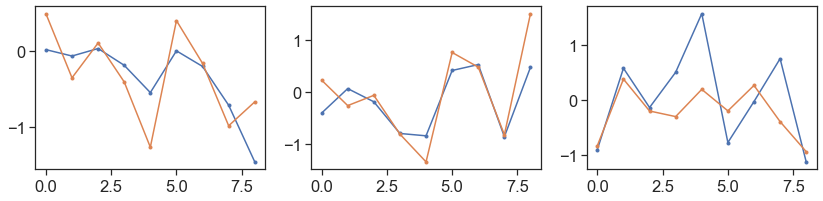

In [150]:
plt.figure(figsize=(14,3))

for i in range(dim):
    
    plt.subplot(1,dim,i+1)
    plt.plot((np.linalg.matrix_power(Ainf,1)@x)[:,i],marker='.')
    plt.plot((np.linalg.matrix_power(A,1)@x)[:,i],marker='.')
    #plt.

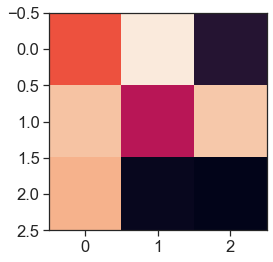

In [151]:
plt.imshow(Ainf)

# Check MCMC fit

# Get this to work with cell activity with structured noise

In [692]:
n_neurons = 120
dim = 3
nT = 9

frac_noise_dynamics = .3

x0 = np.random.normal(size=(dim,1))
A_ = np.random.normal(size=(dim,dim))

A = np.zeros([dim,dim])

for i in range(dim):
    A[i,i:] = A_[i:,i]
    A[i:,i] = -A_[i:,i]
    
A[np.diag_indices_from(A)] = 0
A = (np.eye(dim)-A)@np.linalg.inv(np.eye(dim)+A)

x = np.array([np.linalg.matrix_power(A,i)@x0 for i in range(nT)])

x = frac_noise_dynamics*x #+ (1-frac_noise_dynamics)*np.random.normal(size=x.shape)


W = np.random.normal(size=(n_neurons,dim))
basis_tensor = get_basis_tensor(dim)
n_bases = basis_tensor.shape[0]

In [693]:
def get_spatial_tuning(poke_pos,peak_loc,width):
    """"""
    #for i in range(9):
    distance_matrix = np.abs((poke_pos[peak_loc]-poke_pos)**2).sum(axis=1)
    fr = norm(scale=width).pdf(distance_matrix)
    return fr#distance_matrix
        
def get_task_tuning_line(seq,peak_loc,width):
    task_dists = np.abs(peak_loc-np.arange(9))
#     fr = norm(scale=width).pdf(task_dists)
    fr = np.sin(task_dists)
    return fr[seq]#task_dists[seq]#[task_dists[i] for i in seq]#fr#[fr[i] for i in seq]

In [694]:



act_matrix = []
for nix in range(n_neurons):
    peak_space = np.random.randint(0,9)
    std_space = np.random.randint(1000,12000)
    
    lamda1 = get_spatial_tuning(poke_pos,peak_space,std_space)
    lamda1 = lamda1/np.max(lamda1)
    
    #peak_t1 = np.random.randint(0,9)
    #std_t1 = np.random.randint(3,6)
    #lamda2 = 1*get_task_tuning_line(seq01,peak_t1,std_t1)
    #lamda2 = lamda2/np.max(lamda2)
    #task_tuning = 
    
    
    #peak_t2= np.random.randint(0,9)
    #std_t2 = np.random.randint(1,40)/10.
    w1 = np.random.normal()
    w2 = np.random.normal()
    activity = lamda1 + lamda2 + np.random.normal(scale=.1,size=9)
    act_matrix.append(activity.copy())
act_matrix = np.array(act_matrix).T

NameError: name 'poke_pos' is not defined